In [1]:
import datetime
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import calendar

%matplotlib inline

# Load Data

In [2]:
df_air_reserve =       pd.read_csv("../data/raw/air_reserve.csv", parse_dates=['visit_datetime', 'reserve_datetime'])
df_air_store_info =    pd.read_csv("../data/raw/air_store_info.csv")
df_air_visit_data =    pd.read_csv("../data/raw/air_visit_data.csv", parse_dates=['visit_date'])

df_hpg_reserve =       pd.read_csv("../data/raw/hpg_reserve.csv", parse_dates=['visit_datetime', 'reserve_datetime'])
df_hpg_store_info =    pd.read_csv("../data/raw/hpg_store_info.csv")

df_date_info =         pd.read_csv("../data/raw/date_info.csv", parse_dates=['calendar_date'])
df_store_id_relation = pd.read_csv("../data/raw/store_id_relation.csv")

df_sample_submission = pd.read_csv("../data/raw/sample_submission.csv")

# Overview: File structure and content

### Air Visits

In [3]:
df_air_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null datetime64[ns]
visitors        252108 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.8+ MB


In [4]:
df_air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


### Air Reserve

In [5]:
df_air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null datetime64[ns]
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB


In [6]:
df_air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


### Air Store Info

In [7]:
df_air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null datetime64[ns]
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB


In [8]:
df_air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


### HPG Reserve

In [9]:
df_hpg_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
hpg_store_id        object
visit_datetime      datetime64[ns]
reserve_datetime    datetime64[ns]
reserve_visitors    int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 61.0+ MB


In [10]:
df_hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


### HPG Store Info

In [11]:
df_hpg_store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


In [12]:
df_hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


### Date Info

In [13]:
df_date_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
calendar_date    517 non-null datetime64[ns]
day_of_week      517 non-null object
holiday_flg      517 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.2+ KB


In [14]:
df_date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### Sample Submission

In [15]:
df_sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 2 columns):
id          32019 non-null object
visitors    32019 non-null int64
dtypes: int64(1), object(1)
memory usage: 500.4+ KB


In [16]:
df_sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


# Individual Feature Visualization

#### DATA PREPROCESSING

In [17]:
# set DateTime index to perform visualizations
df_date_info.set_index('calendar_date', inplace=True)

df_holidays = df_date_info[df_date_info['holiday_flg'] == True]

In [18]:
df_holidays.head()

,day_of_week,holiday_flg
calendar_date,,
2016-01-01,Friday,1
2016-01-02,Saturday,1
2016-01-03,Sunday,1
2016-01-11,Monday,1
2016-02-11,Thursday,1


## Air Visits

In [19]:
# set DateTime index to perform visualizations
df_air_visit_data.set_index('visit_date', inplace=True)

#### STATISTICS ON NUMBER OF VISITORS PER DAY IN THE WHOLE TIME FRAME

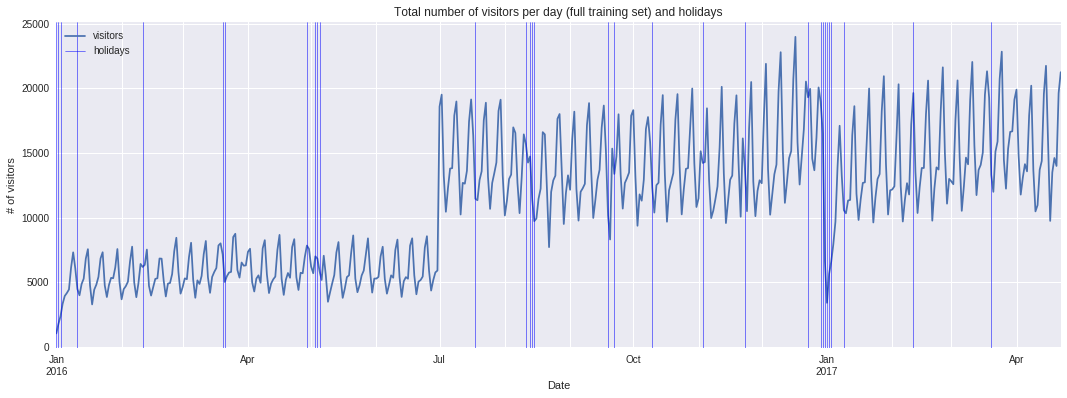

In [20]:
# display statistics per day
visits_daily = df_air_visit_data.resample('D').sum()
ax = visits_daily.plot(figsize=(18,6), title='Total number of visitors per day (full training set) and holidays');

# display holidays
for index, row in df_holidays.iterrows():
    ax.axvline(x=index, color='b', linewidth=0.5, label='holidays');

# plot styling
ax.set_xlabel("Date")
ax.set_ylabel("# of visitors");

ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')
    
ax.legend(['visitors', 'holidays']);

#### STATISTICS ON NUMBER OF VISITORS PER MONTH

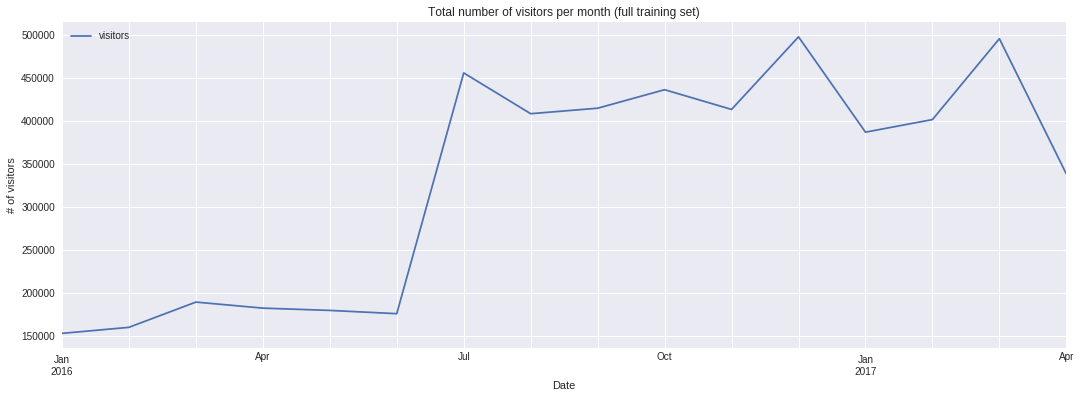

In [21]:
# display statistics per month
visits_monthly = df_air_visit_data.resample('M').sum()
ax = visits_monthly.plot(figsize=(18,6), title='Total number of visitors per month (full training set)');

ax.set_xlabel("Date")
ax.set_ylabel("# of visitors");

ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')

#### MOST COMMON NUMBER OF VISITORS PER RESTAURANT PER DAY

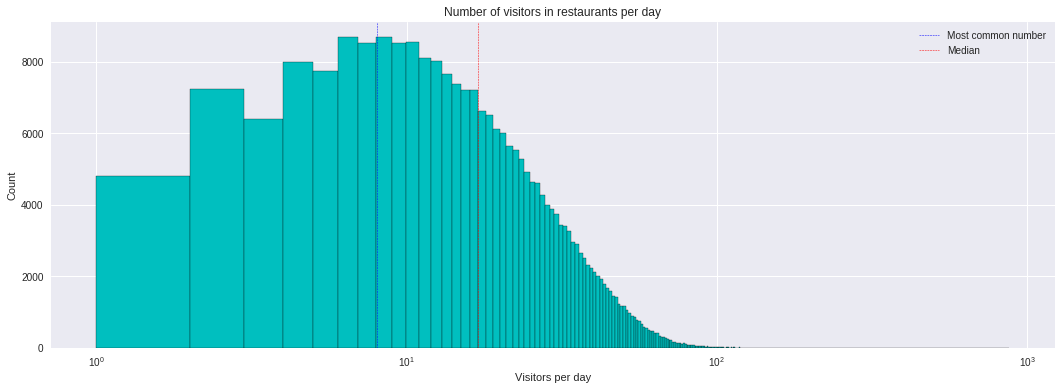

In [22]:
# determine number of bins to use
bin_counts = np.bincount(df_air_visit_data['visitors'])

# display bins
ax = df_air_visit_data['visitors'].hist(bins=len(bin_counts), figsize=(18,6), color='c', edgecolor='black');

# display mode (most common value)
ax.axvline(x=np.argmax(bin_counts), color='b', linewidth=0.5, linestyle='dashed');
# display median
ax.axvline(x=df_air_visit_data['visitors'].median(), color='r', linewidth=0.5, linestyle='dashed');

# plot styling
ax.set_xscale('log')

ax.set_title("Number of visitors in restaurants per day")
ax.set_xlabel("Visitors per day")
ax.set_ylabel("Count");

ax.legend(['Most common number', 'Median']);

In [23]:
print("Most common number of visitors in restaurants per day is {0} (occurred {1} times)." \
          .format(np.argmax(bin_counts), np.max(bin_counts)))

Most common number of visitors in restaurants per day is 8 (occurred 8685 times).


#### STATISTICS ON NUMBER OF VISITORS PER RESTAURANT PER WEEKDAY

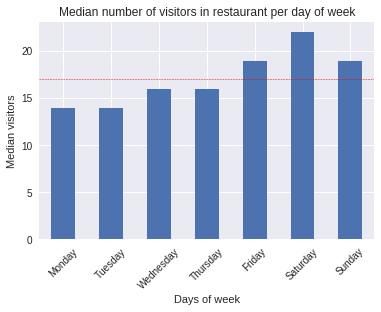

In [24]:
# create new columns
df_air_visit_data['visit_date'] = df_air_visit_data.index
df_air_visit_data['weekday'] = df_air_visit_data['visit_date'].dt.dayofweek
df_air_visit_data['weekday_name'] = df_air_visit_data['visit_date'].dt.weekday_name

# group data by weekday
visits_per_weekday = \
    df_air_visit_data[['weekday', 'weekday_name', 'visitors']] \
        .groupby(['weekday', 'weekday_name']) \
        .agg(['median']) \
        .sort_index(ascending=True)

# display data
ax = visits_per_weekday.plot(kind='bar')

# plot styling
ax.set_title("Median number of visitors in restaurant per day of week")
ax.set_xlabel("Days of week")
ax.set_ylabel("Median visitors");
ax.legend_.remove()

ax.set_xticklabels(list(calendar.day_name), rotation=45);
ax.axhline(y=df_air_visit_data['visitors'].median(), color='r', linewidth=0.5, linestyle='dashed');

#### STATISTICS ON NUMBER OF VISITORS PER RESTAURANT PER MONTH

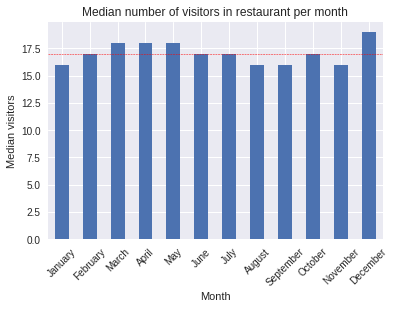

In [25]:
# create new columns
df_air_visit_data['month'] = df_air_visit_data['visit_date'].dt.month

# group data by weekday
visits_per_weekday = \
    df_air_visit_data[['month', 'visitors']] \
        .groupby(['month']) \
        .agg(['median']) \
        .sort_index(ascending=True)

# display data
ax = visits_per_weekday.plot(kind='bar')

# plot styling
ax.set_title("Median number of visitors in restaurant per month")
ax.set_xlabel("Month")
ax.set_ylabel("Median visitors");
ax.legend_.remove()

ax.set_xticklabels(list(calendar.month_name)[1:], rotation=45);
ax.axhline(y=df_air_visit_data['visitors'].median(), color='r', linewidth=0.5, linestyle='dashed');

## Air Reservations

In [26]:
# create new columns
df_air_reserve['visit_datetime_weekdayname'] = df_air_reserve['visit_datetime'].dt.weekday_name
df_air_reserve['reserve_datetime_weekdayname'] = df_air_reserve['reserve_datetime'].dt.weekday_name

df_air_reserve['visit_datetime_month'] = df_air_reserve['visit_datetime'].dt.month
df_air_reserve['reserve_datetime_month'] = df_air_reserve['reserve_datetime'].dt.month

#### STATISTICS ON HOURLY TRENDS FOR MAKING RESERVATIONS

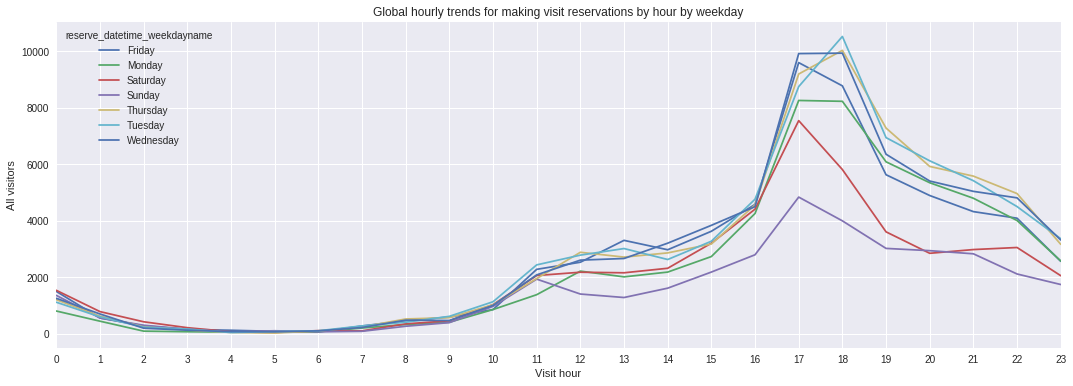

In [27]:
air_reserve_byhour_byweekday = \
    df_air_reserve.pivot_table(index=df_air_reserve['reserve_datetime'].dt.hour, 
    columns='reserve_datetime_weekdayname', 
    values='reserve_visitors', 
    aggfunc='sum')

ax = air_reserve_byhour_byweekday.plot(
        figsize=(18,6), 
        title='Global hourly trends for making visit reservations by hour by weekday',
        xticks=np.arange(0, 24, 1))
 
ax.set_xlabel("Visit hour")
ax.set_ylabel("All visitors");

#### STATISTICS ON HOURLY TRENDS FOR VISITS IN RESTAURANTS

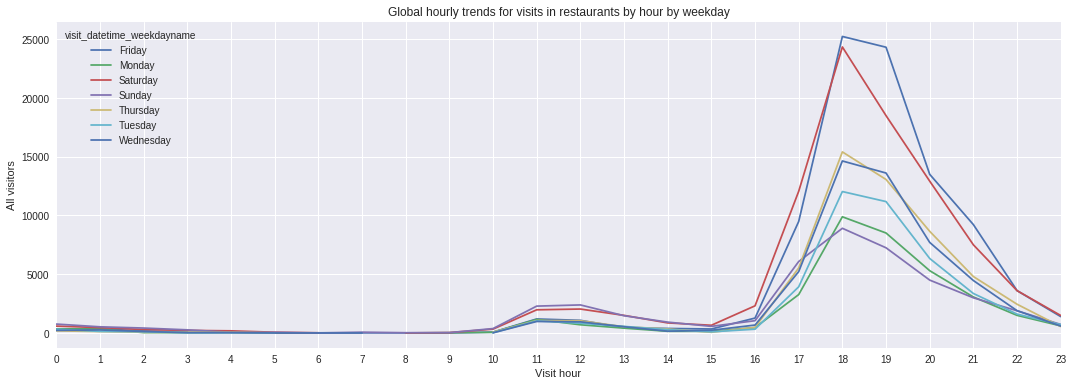

In [28]:
air_visit_byhour_byweekday = \
    df_air_reserve.pivot_table(index=df_air_reserve['visit_datetime'].dt.hour, 
    columns='visit_datetime_weekdayname', 
    values='reserve_visitors', 
    aggfunc='sum')

ax = air_visit_byhour_byweekday.plot(
        figsize=(18,6), 
        title='Global hourly trends for visits in restaurants by hour by weekday',
        xticks=np.arange(0, 24, 1))
 
ax.set_xlabel("Visit hour")
ax.set_ylabel("All visitors");

#### RESERVATION DATA VS ACTUAL VISITOR NUMBERS

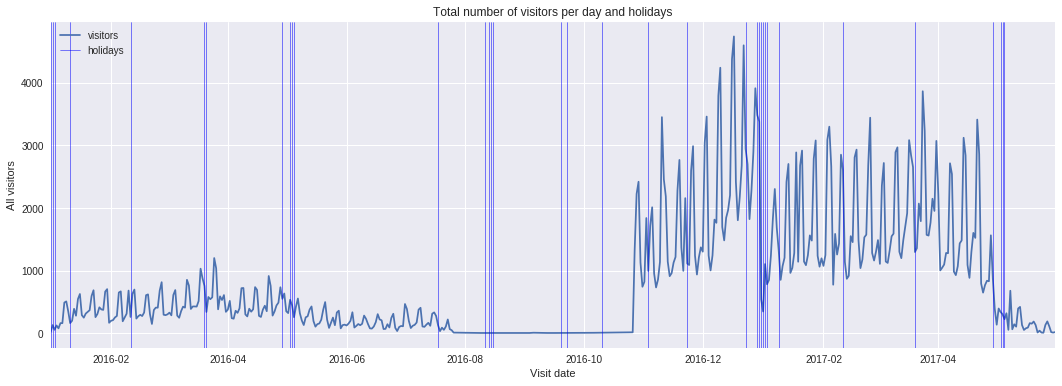

In [29]:
# prepare dataset
air_reservations = pd.DataFrame()
air_reservations['visit_date'] = df_air_reserve['visit_datetime'].dt.date
air_reservations['reserve_visitors'] = df_air_reserve['reserve_visitors']

# reservations by weekday
air_reservations_per_weekday = \
    air_reservations[['visit_date', 'reserve_visitors']] \
        .groupby(['visit_date']) \
        .agg(['sum']) \
        .sort_index(ascending=True)

# display data
ax = air_reservations_per_weekday.plot(figsize=(18,6))

# display holidays
for index, row in df_holidays.iterrows():
    ax.axvline(x=index, color='b', linewidth=0.5);

# plot styling
ax.set_title("Total number of visitors per day and holidays")
ax.set_xlabel("Visit date")
ax.set_ylabel("All visitors");

ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')
    
ax.legend(['visitors', 'holidays']);

#### TIME FROM RESERVATION TO VISIT

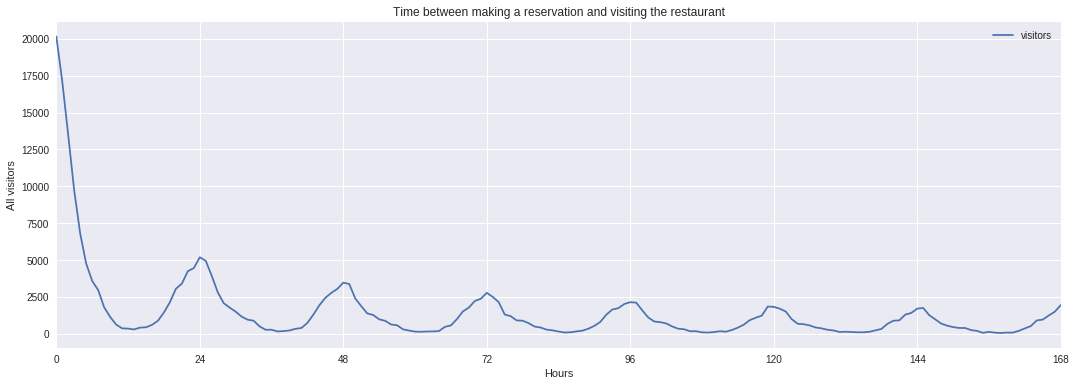

In [30]:
df_air_reserve['reserve_visit_diff'] = \
    (df_air_reserve['visit_datetime'] - df_air_reserve['reserve_datetime']) / np.timedelta64(1, 'h')

air_reserve_visit_diff = \
    df_air_reserve[df_air_reserve['reserve_visit_diff'] <= 7*24][['reserve_visit_diff', 'reserve_visitors']] \
        .groupby(['reserve_visit_diff']) \
        .agg(['sum']) \
        .sort_index(ascending=True)          

# display data
ax = air_reserve_visit_diff.plot(figsize=(18,6))

# plot styling
ax.set_title("Time between making a reservation and visiting the restaurant")
ax.set_xlabel("Hours")
ax.set_ylabel("All visitors");
    
ax.legend(['visitors', 'holidays']);

import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

## HPG Reservations

In [31]:
# create new columns
df_hpg_reserve['visit_datetime_weekdayname'] = df_hpg_reserve['visit_datetime'].dt.weekday_name
df_hpg_reserve['reserve_datetime_weekdayname'] = df_hpg_reserve['reserve_datetime'].dt.weekday_name

df_hpg_reserve['visit_datetime_month'] = df_hpg_reserve['visit_datetime'].dt.month
df_hpg_reserve['reserve_datetime_month'] = df_hpg_reserve['reserve_datetime'].dt.month

#### STATISTICS ON HOURLY TRENDS FOR MAKING RESERVATIONS

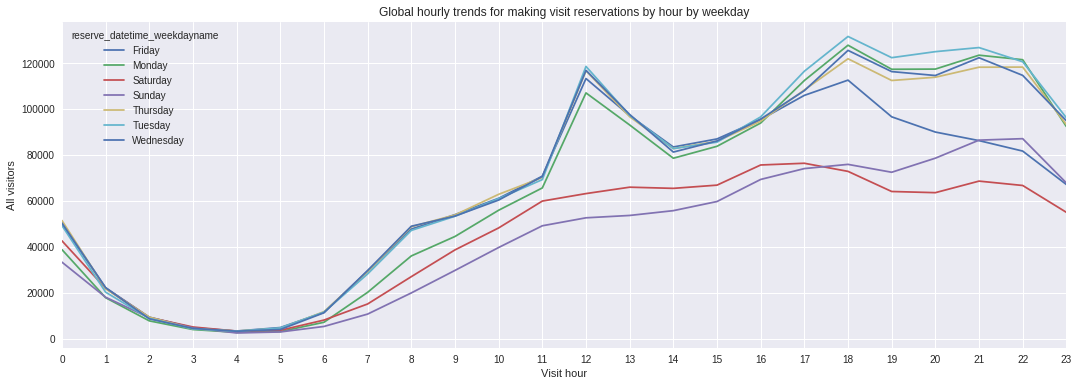

In [32]:
hpg_reserve_byhour_byweekday = \
    df_hpg_reserve.pivot_table(index=df_hpg_reserve['reserve_datetime'].dt.hour, 
    columns='reserve_datetime_weekdayname', 
    values='reserve_visitors', 
    aggfunc='sum')

ax = hpg_reserve_byhour_byweekday.plot(
        figsize=(18,6), 
        title='Global hourly trends for making visit reservations by hour by weekday',
        xticks=np.arange(0, 24, 1))
 
ax.set_xlabel("Visit hour")
ax.set_ylabel("All visitors");

#### STATISTICS ON HOURLY TRENDS FOR VISITS IN RESTAURANTS

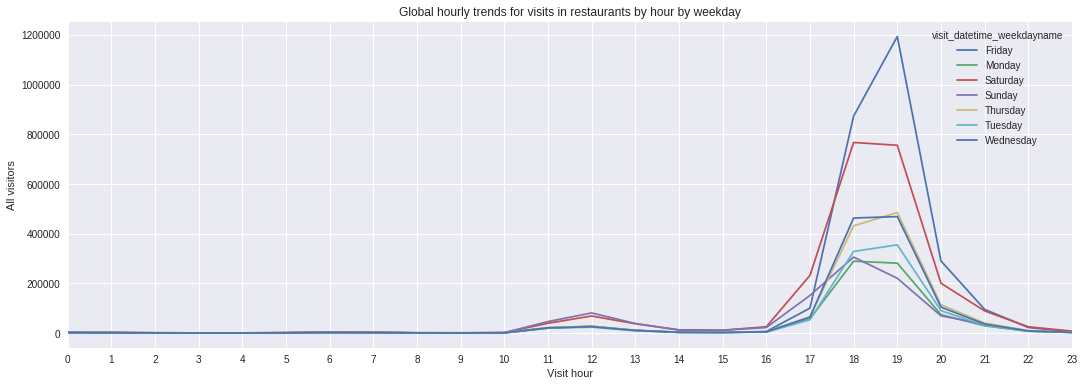

In [33]:
hpg_visit_byhour_byweekday = \
    df_hpg_reserve.pivot_table(index=df_hpg_reserve['visit_datetime'].dt.hour, 
    columns='visit_datetime_weekdayname', 
    values='reserve_visitors', 
    aggfunc='sum')

ax = hpg_visit_byhour_byweekday.plot(
        figsize=(18,6), 
        title='Global hourly trends for visits in restaurants by hour by weekday',
        xticks=np.arange(0, 24, 1))
 
ax.set_xlabel("Visit hour")
ax.set_ylabel("All visitors");

#### RESERVATION DATA VS ACTUAL VISITOR NUMBERS

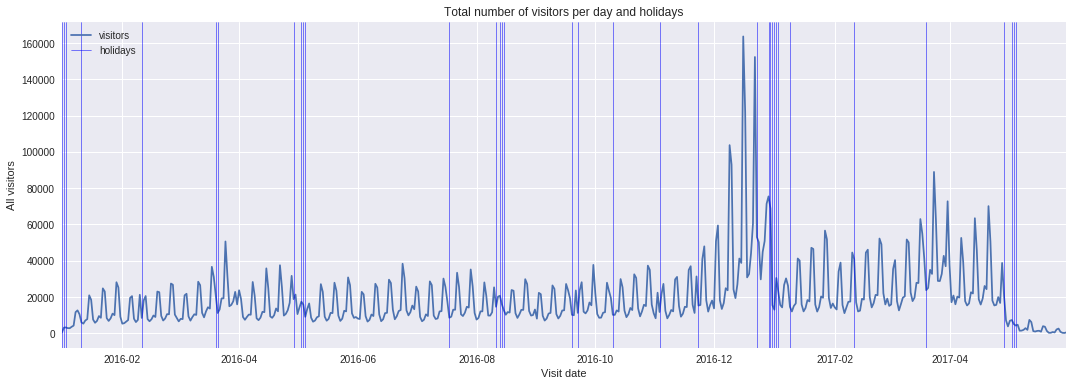

In [34]:
# prepare dataset
hpg_reservations = pd.DataFrame()
hpg_reservations['visit_date'] = df_hpg_reserve['visit_datetime'].dt.date
hpg_reservations['reserve_visitors'] = df_hpg_reserve['reserve_visitors']

# reservations by weekday
hpg_reservations_per_weekday = \
    hpg_reservations[['visit_date', 'reserve_visitors']] \
        .groupby(['visit_date']) \
        .agg(['sum']) \
        .sort_index(ascending=True)

# display data
ax = hpg_reservations_per_weekday.plot(figsize=(18,6))

# display holidays
for index, row in df_holidays.iterrows():
    ax.axvline(x=index, color='b', linewidth=0.5);

# plot styling
ax.set_title("Total number of visitors per day and holidays")
ax.set_xlabel("Visit date")
ax.set_ylabel("All visitors");

ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')
    
ax.legend(['visitors', 'holidays']);

#### TIME FROM RESERVATION TO VISIT

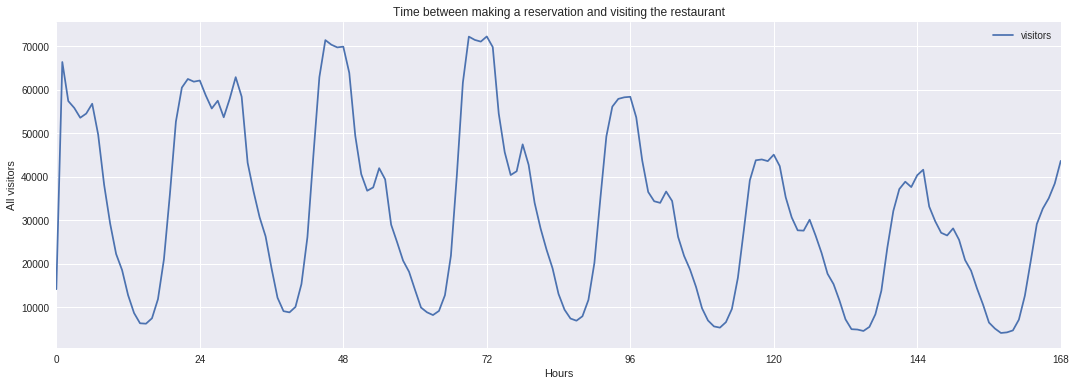

In [35]:
df_hpg_reserve['reserve_visit_diff'] = \
    (df_hpg_reserve['visit_datetime'] - df_hpg_reserve['reserve_datetime']) / np.timedelta64(1, 'h')

hpg_reserve_visit_diff = \
    df_hpg_reserve[df_hpg_reserve['reserve_visit_diff'] <= 7*24][['reserve_visit_diff', 'reserve_visitors']] \
        .groupby(['reserve_visit_diff']) \
        .agg(['sum']) \
        .sort_index(ascending=True)          

# display data
ax = hpg_reserve_visit_diff.plot(figsize=(18,6))

# plot styling
ax.set_title("Time between making a reservation and visiting the restaurant")
ax.set_xlabel("Hours")
ax.set_ylabel("All visitors");
    
ax.legend(['visitors', 'holidays']);

import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))